In [24]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import csv
import warnings
import glob

In [25]:
warnings.filterwarnings("ignore")

In [26]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index.astype(str), df[column], color=color) 
        plt.xlabel('Ano')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [27]:
def centered_moving_average(column, window_action, window_size):
    start_index, end_index = window_action
    data = column.to_numpy()

    data_length = len(data)

    for i in range(start_index, end_index + 1):
        if not np.isnan(data[i]):
            init = data[i]
            start = max(0, i - window_size)
            end = min(data_length, i + window_size + 1)
            window = data[start:end]
            valid_values = [value for value in window if not pd.isna(value)]
            if len(valid_values) > 0:
                data[i] = np.mean(valid_values)

    modified_column = pd.Series(data, name=column.name)

    return modified_column

In [28]:
# Linear Interpolation 
def ends_filler(column):
    if  column.dtype.kind in ['i', 'f']:
            column = first_filler(column)
            column = last_filler(column)
    return column

def first_filler(column):
    if pd.isnull(column.at[0]) or np.isnan(column.at[0]):
        size = len(column) -1
        first_valid_index = 0
        while first_valid_index <= size and (pd.isnull(column.at[first_valid_index]) or np.isnan(column.at[first_valid_index])):
            first_valid_index += 1
        if first_valid_index > size:
            column.at[0] = 0.0
        else:
            column.at[0] = column.at[first_valid_index]
    return column
    
def last_filler(column):
    if pd.isnull(column.at[len(column) -1]) or np.isnan(column.at[len(column) -1]):  
        last_valid_index = len(column) -1
        while last_valid_index >= 0 and (pd.isnull(column.at[last_valid_index]) or np.isnan(column.at[last_valid_index])):
            last_valid_index -= 1
        if last_valid_index < 0:
            column.at[len(column) -1] = 0.0
        else:
            column.at[len(column) -1] = column.at[last_valid_index]
    return column
    
def prev_valid_index(column, pos):
    prev_index = pos
    size = len(column) -1
    if pos > 0 and pos < size:
        while prev_index >= 0 and (pd.isnull(column.at[prev_index]) or np.isnan(column.at[prev_index])):
            prev_index -= 1
    return prev_index  

def next_valid_index(column, pos):
    next_index = pos
    size = len(column) -1
    if pos > 0 and pos < size:
        while next_index <= size and (pd.isnull(column.at[next_index]) or np.isnan(column.at[next_index])):
            next_index += 1
    return next_index

def linear_filler(column):
    if column.isnull().any():
        for i, value in enumerate(column):
            if i > 0 and (pd.isnull(value) or np.isnan(value) or (value == '')):
                start = prev_valid_index(column, i)
                end = next_valid_index(column, i)
                gap = list(range(start + 1, end))
                linear_a = (column.at[end] - column.at[start])/(end - start)
                linear_b = column.at[start] - linear_a*start
                for x in gap:
                    column.at[x] = linear_a*x + linear_b
    return column 

In [29]:
def add_month(df):
    new_index = [] 
    for i, index_value in enumerate(df.index):
        iteration = i % 12 + 1
        new_index.append(f'{index_value}-{iteration}')
    df.index = new_index

    return df

In [30]:
def read_csv_replace_missing_by_linear(file_path, skiped_rows):
    with open(file_path, 'r') as f:
        
        df = pd.read_csv(file_path, skiprows=skiped_rows)
        
        i = 0
        for col in df.columns: # Elimina missing values por médias e transforma em float
            if i > 0:
                df[col] = df[col].replace('-9999', np.nan)
                df[col] = df[col].replace('-', np.nan)
                df[col] = df[col].replace('', np.nan).astype(float)
                df[col] = ends_filler(df[col])
                df[col] = linear_filler(df[col])
#                 df[col] = centered_moving_average(df[col], (0, len(df[col]) - 1), 24) #2 anos
            i += 1
        return df

In [31]:
df = pd.read_csv("consumo_cimento_mensal_pre_proc.csv")
df

,Ano,Rondônia - Consumo de Cimento (t),Acre - Consumo de Cimento (t),Amazonas - Consumo de Cimento (t),Roraima - Consumo de Cimento (t),Pará - Consumo de Cimento (t),Amapá - Consumo de Cimento (t),Tocantins - Consumo de Cimento (t),Maranhão - Consumo de Cimento (t),Piauí - Consumo de Cimento (t),...,Espírito Santo - Consumo de Cimento (t),Rio De Janeiro - Consumo de Cimento (t),São Paulo - Consumo de Cimento (t),Paraná - Consumo de Cimento (t),Santa Catarina - Consumo de Cimento (t),Rio Grande Do Sul - Consumo de Cimento (t),Mato Grosso - Consumo de Cimento (t),Mato Grosso Do Sul - Consumo de Cimento (t),Goiás - Consumo de Cimento (t),Distrito Federal - Consumo de Cimento (t)
0,2003-01,13.867,3.260,28.193,6.920,84.701,10.392,17.555,43.342,21.844,...,48.426,254.362,782.111,189.804,142.456,188.093,47.470,33.744,97.447,50.047
1,2003-02,10.777,2.191,31.226,7.476,80.221,6.857,14.976,28.663,15.814,...,54.969,252.842,789.891,174.713,135.829,170.973,45.387,32.230,97.256,48.110
2,2003-03,13.888,2.154,33.484,8.659,76.122,7.011,13.334,27.900,16.067,...,53.847,229.385,774.309,180.801,133.135,174.880,44.907,33.559,101.442,49.006
3,2003-04,11.859,2.643,31.596,7.259,76.544,7.122,15.173,25.739,14.938,...,50.375,243.407,782.071,180.172,144.723,178.111,45.467,34.283,98.217,48.445
4,2003-05,14.431,2.546,32.919,6.786,83.445,5.267,18.728,30.203,17.765,...,52.576,256.535,841.400,185.597,150.523,184.331,56.246,36.066,112.540,51.436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-08,49.066,21.748,66.077,9.133,156.442,13.208,54.154,102.698,77.776,...,100.170,241.702,1112.914,412.177,377.545,288.217,192.533,103.854,274.673,77.448
236,2022-09,49.850,20.032,58.590,10.622,145.777,13.476,55.664,98.133,72.377,...,85.832,221.036,1028.144,337.056,370.282,272.178,183.895,95.890,247.240,64.321
237,2022-10,43.733,18.573,58.793,10.300,139.233,11.236,52.320,94.964,71.791,...,91.318,224.399,996.449,340.018,340.900,272.665,180.525,89.679,246.647,72.839
238,2022-11,40.078,15.493,53.509,10.258,142.025,13.549,43.036,97.684,71.015,...,77.187,221.319,1024.272,383.477,363.900,275.972,161.683,99.356,225.813,59.598


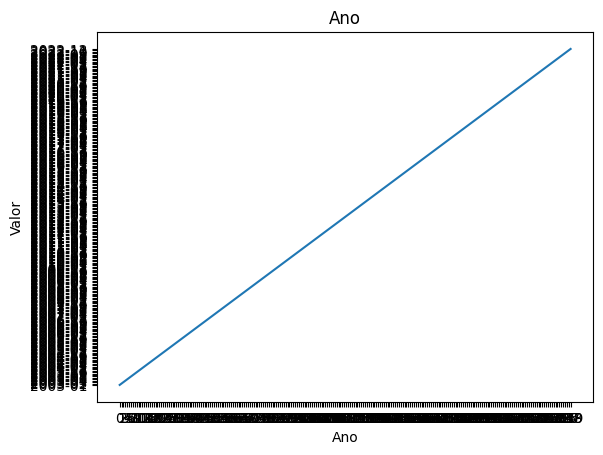

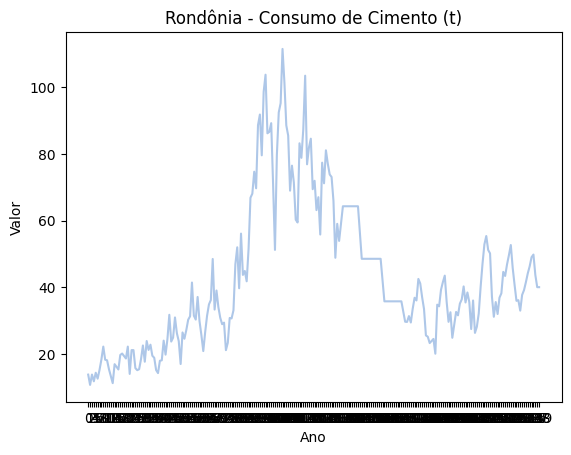

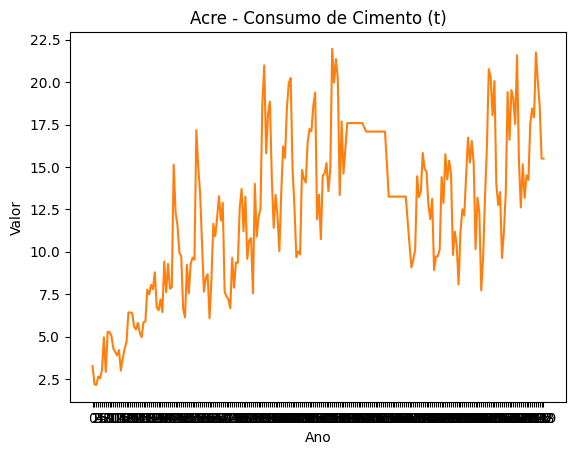

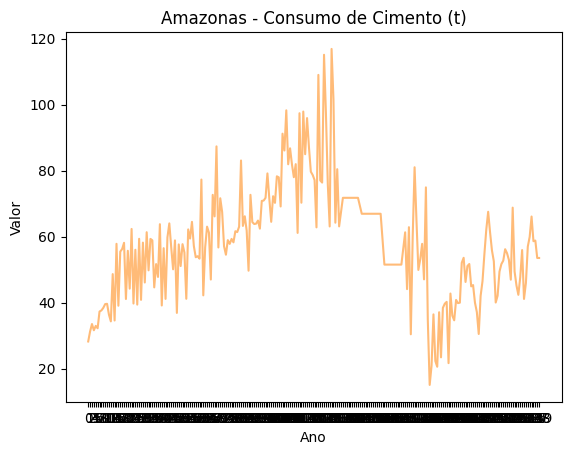

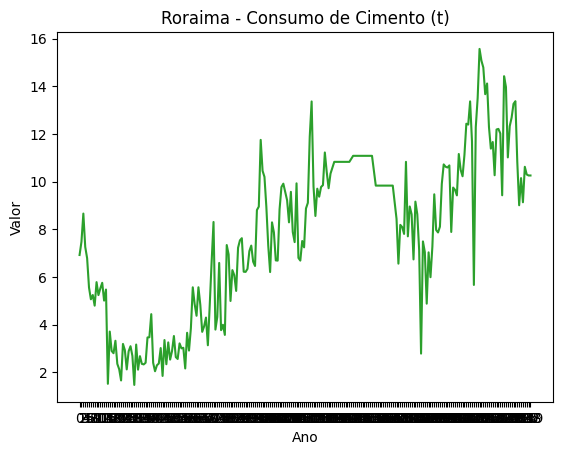

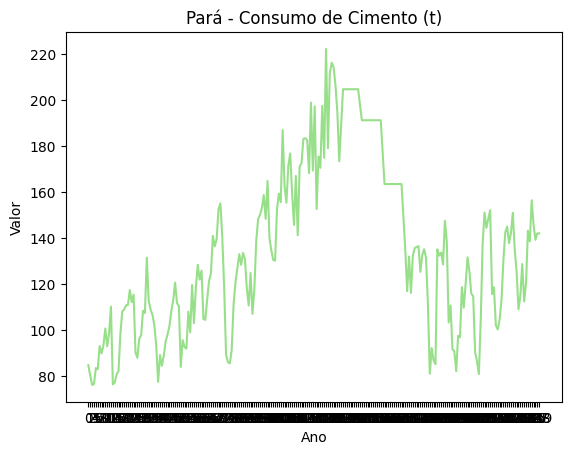

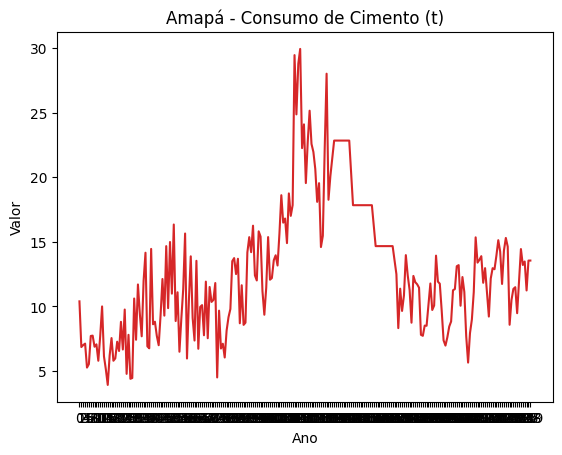

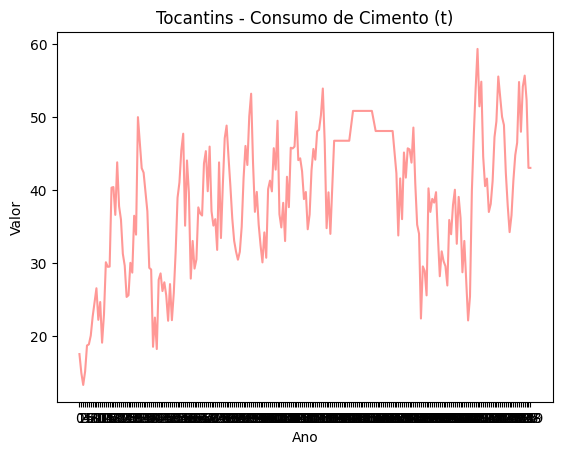

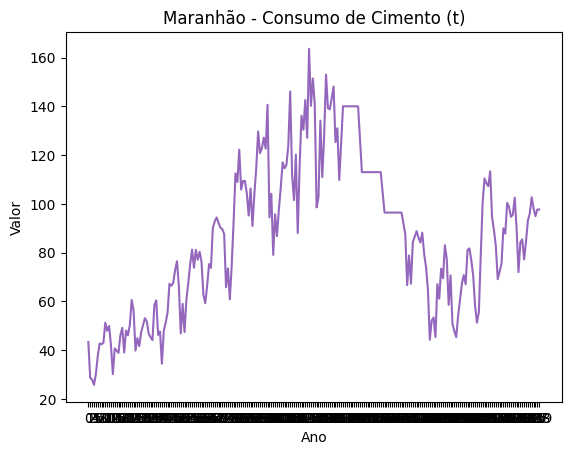

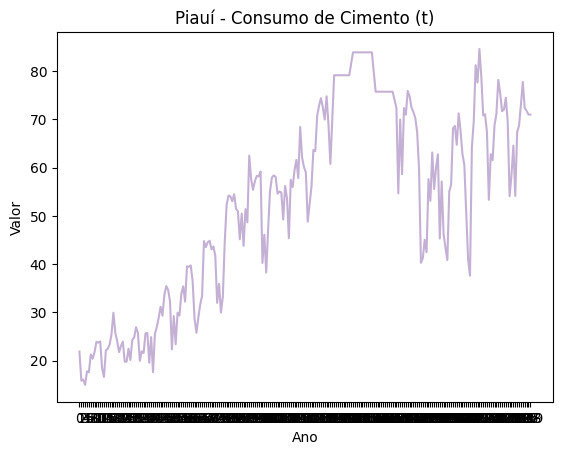

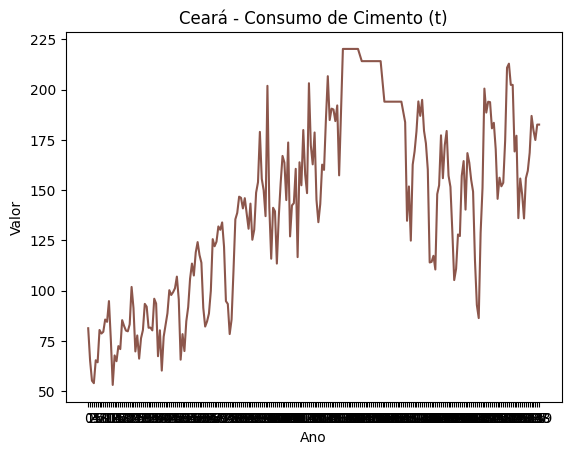

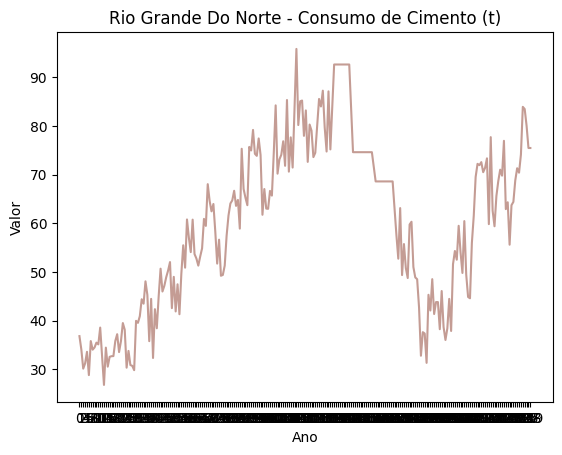

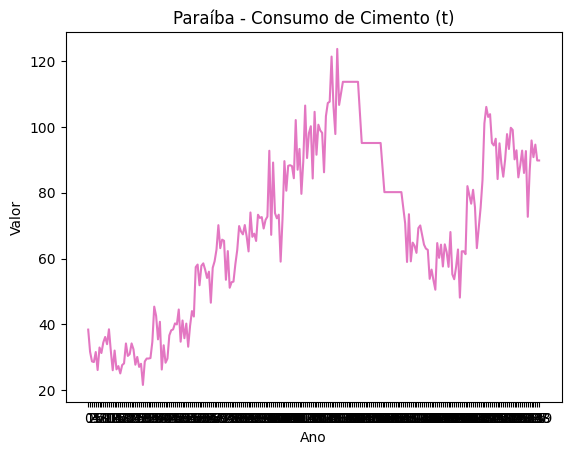

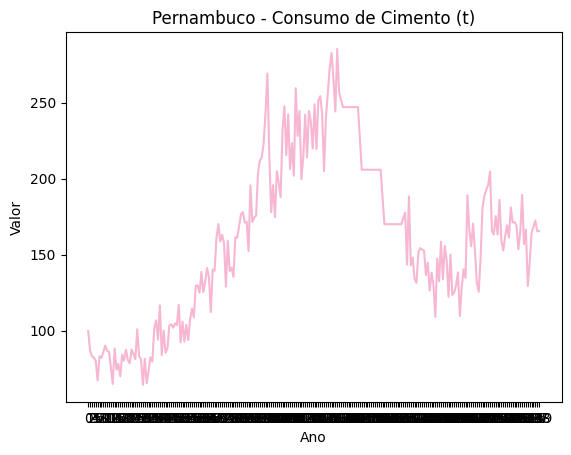

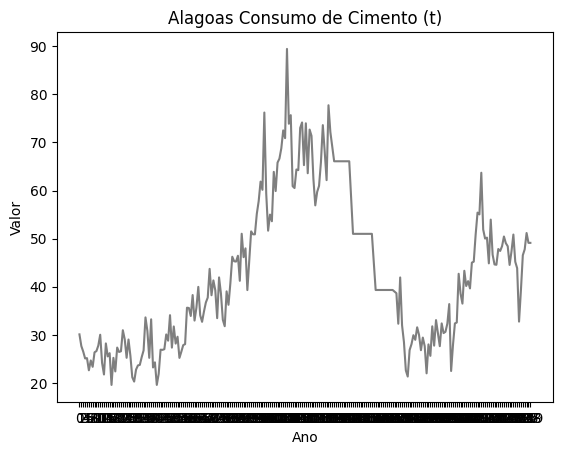

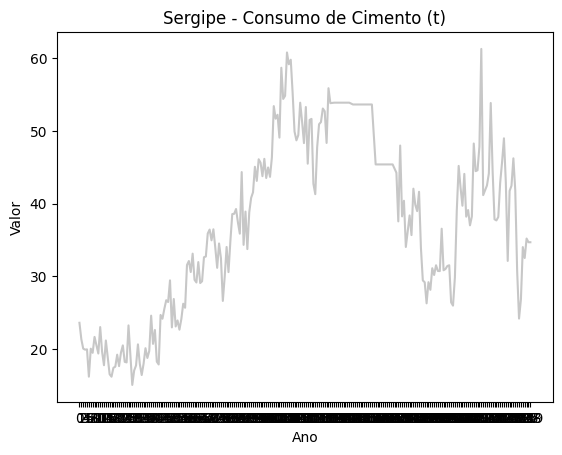

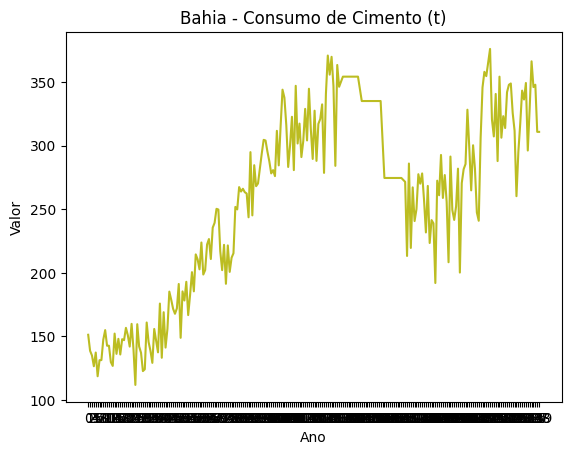

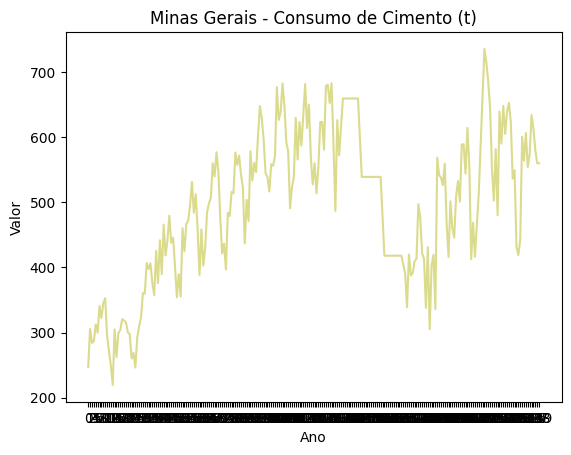

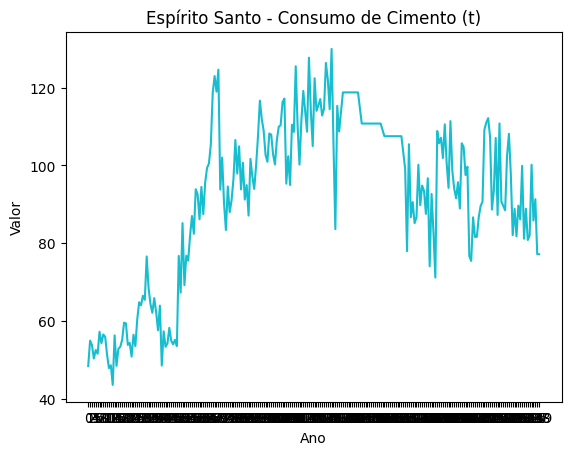

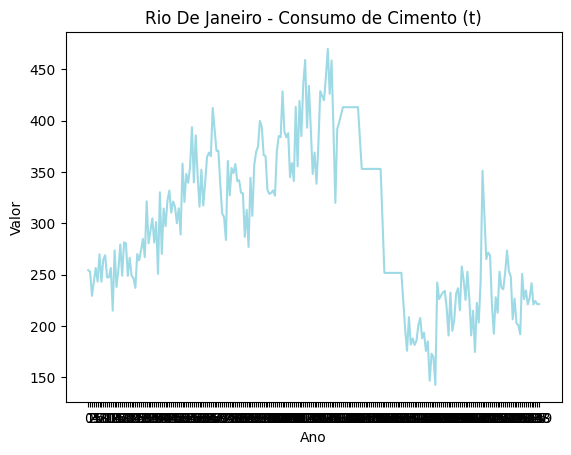

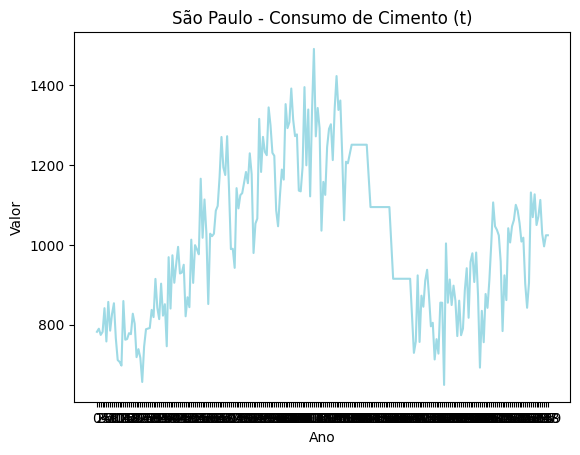

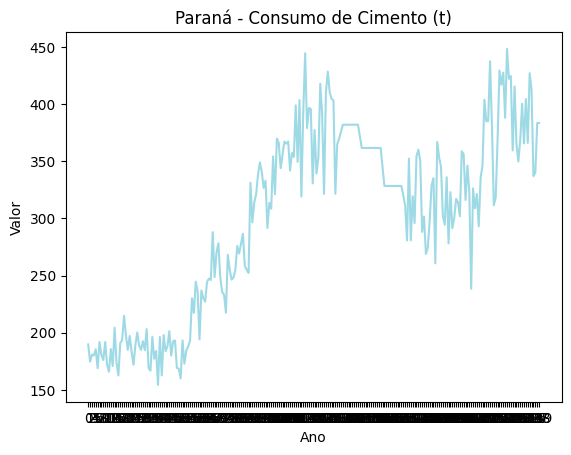

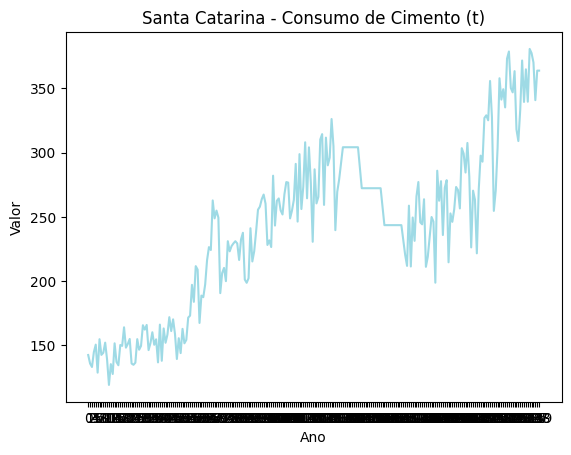

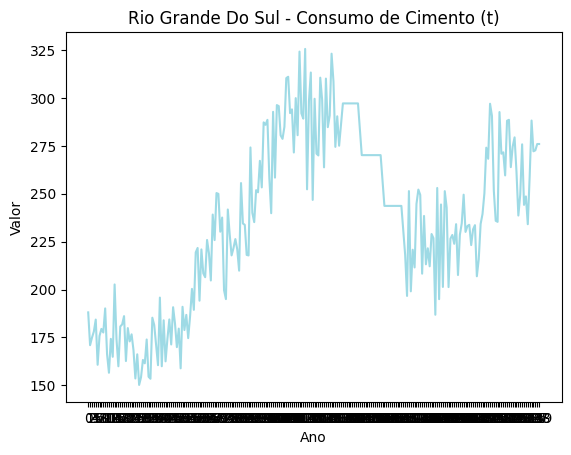

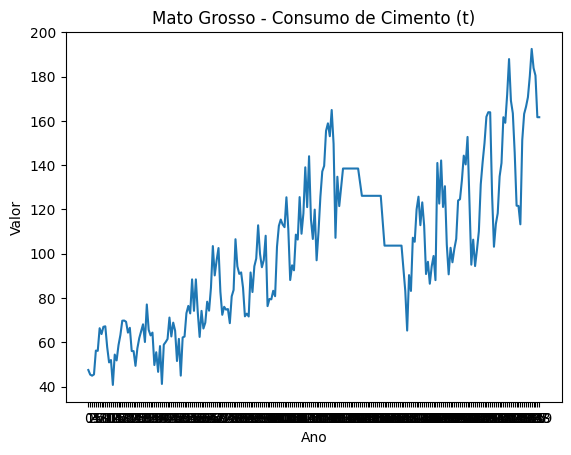

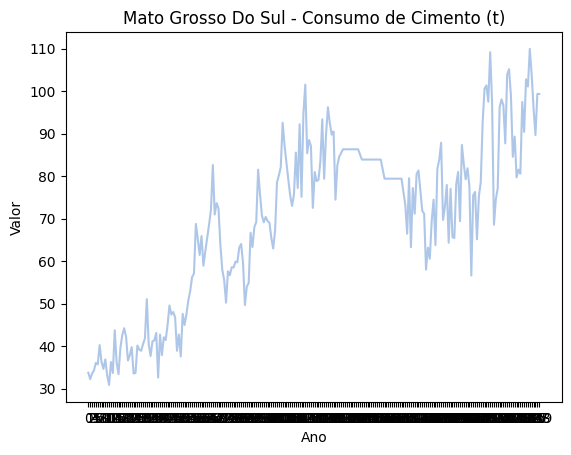

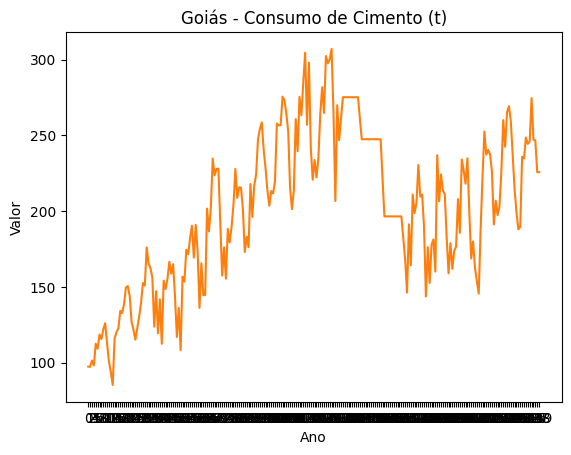

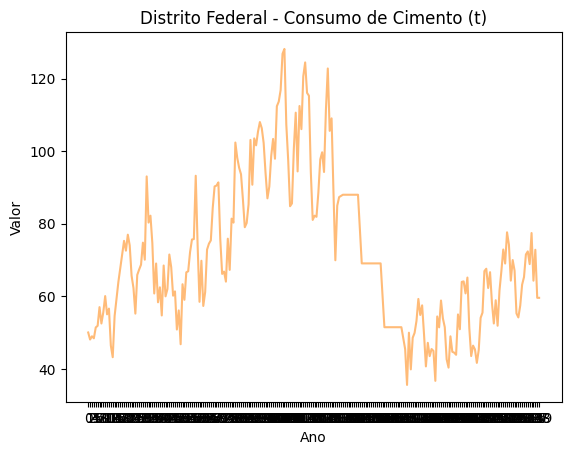

,Ano,Rondônia - Consumo de Cimento (t),Acre - Consumo de Cimento (t),Amazonas - Consumo de Cimento (t),Roraima - Consumo de Cimento (t),Pará - Consumo de Cimento (t),Amapá - Consumo de Cimento (t),Tocantins - Consumo de Cimento (t),Maranhão - Consumo de Cimento (t),Piauí - Consumo de Cimento (t),...,Espírito Santo - Consumo de Cimento (t),Rio De Janeiro - Consumo de Cimento (t),São Paulo - Consumo de Cimento (t),Paraná - Consumo de Cimento (t),Santa Catarina - Consumo de Cimento (t),Rio Grande Do Sul - Consumo de Cimento (t),Mato Grosso - Consumo de Cimento (t),Mato Grosso Do Sul - Consumo de Cimento (t),Goiás - Consumo de Cimento (t),Distrito Federal - Consumo de Cimento (t)
0,2003-01,13.867,3.260,28.193,6.920,84.701,10.392,17.555,43.342,21.844,...,48.426,254.362,782.111,189.804,142.456,188.093,47.470,33.744,97.447,50.047
1,2003-02,10.777,2.191,31.226,7.476,80.221,6.857,14.976,28.663,15.814,...,54.969,252.842,789.891,174.713,135.829,170.973,45.387,32.230,97.256,48.110
2,2003-03,13.888,2.154,33.484,8.659,76.122,7.011,13.334,27.900,16.067,...,53.847,229.385,774.309,180.801,133.135,174.880,44.907,33.559,101.442,49.006
3,2003-04,11.859,2.643,31.596,7.259,76.544,7.122,15.173,25.739,14.938,...,50.375,243.407,782.071,180.172,144.723,178.111,45.467,34.283,98.217,48.445
4,2003-05,14.431,2.546,32.919,6.786,83.445,5.267,18.728,30.203,17.765,...,52.576,256.535,841.400,185.597,150.523,184.331,56.246,36.066,112.540,51.436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-08,49.066,21.748,66.077,9.133,156.442,13.208,54.154,102.698,77.776,...,100.170,241.702,1112.914,412.177,377.545,288.217,192.533,103.854,274.673,77.448
236,2022-09,49.850,20.032,58.590,10.622,145.777,13.476,55.664,98.133,72.377,...,85.832,221.036,1028.144,337.056,370.282,272.178,183.895,95.890,247.240,64.321
237,2022-10,43.733,18.573,58.793,10.300,139.233,11.236,52.320,94.964,71.791,...,91.318,224.399,996.449,340.018,340.900,272.665,180.525,89.679,246.647,72.839
238,2022-11,40.078,15.493,53.509,10.258,142.025,13.549,43.036,97.684,71.015,...,77.187,221.319,1024.272,383.477,363.900,275.972,161.683,99.356,225.813,59.598


In [32]:
df = read_csv_replace_missing_by_linear("consumo_cimento_mensal_pre_proc.csv",0)
plot_columns(df)
df

In [33]:
df_month = df.copy()
df_month['Ano'] = df_month['Ano'].str[:4]
df_month = df_month.set_index('Ano', inplace=False)
df_month.index = df_month.index.astype(int)
df_2003 = df_month[df_month.index >= 2003]
df_2003 = add_month(df_2003)
# plot_columns(df_2003)
df_2003

,Rondônia - Consumo de Cimento (t),Acre - Consumo de Cimento (t),Amazonas - Consumo de Cimento (t),Roraima - Consumo de Cimento (t),Pará - Consumo de Cimento (t),Amapá - Consumo de Cimento (t),Tocantins - Consumo de Cimento (t),Maranhão - Consumo de Cimento (t),Piauí - Consumo de Cimento (t),Ceará - Consumo de Cimento (t),...,Espírito Santo - Consumo de Cimento (t),Rio De Janeiro - Consumo de Cimento (t),São Paulo - Consumo de Cimento (t),Paraná - Consumo de Cimento (t),Santa Catarina - Consumo de Cimento (t),Rio Grande Do Sul - Consumo de Cimento (t),Mato Grosso - Consumo de Cimento (t),Mato Grosso Do Sul - Consumo de Cimento (t),Goiás - Consumo de Cimento (t),Distrito Federal - Consumo de Cimento (t)
2003-1,13.867,3.260,28.193,6.920,84.701,10.392,17.555,43.342,21.844,81.265,...,48.426,254.362,782.111,189.804,142.456,188.093,47.470,33.744,97.447,50.047
2003-2,10.777,2.191,31.226,7.476,80.221,6.857,14.976,28.663,15.814,65.200,...,54.969,252.842,789.891,174.713,135.829,170.973,45.387,32.230,97.256,48.110
2003-3,13.888,2.154,33.484,8.659,76.122,7.011,13.334,27.900,16.067,55.165,...,53.847,229.385,774.309,180.801,133.135,174.880,44.907,33.559,101.442,49.006
2003-4,11.859,2.643,31.596,7.259,76.544,7.122,15.173,25.739,14.938,53.928,...,50.375,243.407,782.071,180.172,144.723,178.111,45.467,34.283,98.217,48.445
2003-5,14.431,2.546,32.919,6.786,83.445,5.267,18.728,30.203,17.765,65.334,...,52.576,256.535,841.400,185.597,150.523,184.331,56.246,36.066,112.540,51.436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-8,49.066,21.748,66.077,9.133,156.442,13.208,54.154,102.698,77.776,186.918,...,100.170,241.702,1112.914,412.177,377.545,288.217,192.533,103.854,274.673,77.448
2022-9,49.850,20.032,58.590,10.622,145.777,13.476,55.664,98.133,72.377,179.828,...,85.832,221.036,1028.144,337.056,370.282,272.178,183.895,95.890,247.240,64.321
2022-10,43.733,18.573,58.793,10.300,139.233,11.236,52.320,94.964,71.791,174.940,...,91.318,224.399,996.449,340.018,340.900,272.665,180.525,89.679,246.647,72.839
2022-11,40.078,15.493,53.509,10.258,142.025,13.549,43.036,97.684,71.015,182.597,...,77.187,221.319,1024.272,383.477,363.900,275.972,161.683,99.356,225.813,59.598


In [34]:
def calculate_monthly_means(df_cement):
    monthly_mean_lists = []
    df_cement = df_cement.reset_index(drop=True)
    for column in df_cement.columns:
        df = pd.DataFrame({column: df_cement[column]})
        df['sazonalidade'] = df.index % 12
        monthly_means = df.groupby('sazonalidade')[column].mean()
        result_list = monthly_means.tolist()
        monthly_mean_lists.append(result_list)

    return monthly_mean_lists

monthly_mean_lists = calculate_monthly_means(df_2003)
monthly_mean_lists

[[38.640150000000006,
  34.7254,
  36.817425,
  36.42065,
  42.03825,
  43.8605,
  47.92885,
  51.4696,
  47.45385,
  47.942449999999994,
  45.296949999999995,
  39.75535],
 [10.735125,
  9.4666,
  10.167525000000001,
  10.475999999999999,
  12.0983,
  12.401,
  13.5949,
  15.62765,
  14.529300000000001,
  15.2346,
  13.184199999999999,
  11.159650000000001],
 [55.67554999999999,
  49.6305,
  56.34845,
  52.8726,
  54.979600000000005,
  58.64115,
  61.80695000000001,
  61.2735,
  60.5175,
  64.94494999999999,
  60.66215,
  58.173175],
 [8.143825,
  7.77535,
  8.484300000000001,
  7.945950000000001,
  7.368599999999999,
  6.8006,
  7.50085,
  7.7363,
  7.336449999999999,
  7.773999999999999,
  8.091849999999999,
  8.062675],
 [131.30239999999998,
  113.45965000000001,
  119.62867500000002,
  116.45935,
  126.23554999999999,
  136.23635,
  142.9049,
  144.63695,
  144.02425,
  147.26375000000002,
  146.94729999999998,
  140.85264999999998],
 [12.869475,
  10.51585,
  12.2076,
  11.0618,


In [35]:
df_2003 = df_2003.reset_index(drop=False)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
df_2003

,index,Rondônia - Consumo de Cimento (t),Acre - Consumo de Cimento (t),Amazonas - Consumo de Cimento (t),Roraima - Consumo de Cimento (t),Pará - Consumo de Cimento (t),Amapá - Consumo de Cimento (t),Tocantins - Consumo de Cimento (t),Maranhão - Consumo de Cimento (t),Piauí - Consumo de Cimento (t),...,Espírito Santo - Consumo de Cimento (t),Rio De Janeiro - Consumo de Cimento (t),São Paulo - Consumo de Cimento (t),Paraná - Consumo de Cimento (t),Santa Catarina - Consumo de Cimento (t),Rio Grande Do Sul - Consumo de Cimento (t),Mato Grosso - Consumo de Cimento (t),Mato Grosso Do Sul - Consumo de Cimento (t),Goiás - Consumo de Cimento (t),Distrito Federal - Consumo de Cimento (t)
0,2003-1,13.867,3.260,28.193,6.920,84.701,10.392,17.555,43.342,21.844,...,48.426,254.362,782.111,189.804,142.456,188.093,47.470,33.744,97.447,50.047
1,2003-2,10.777,2.191,31.226,7.476,80.221,6.857,14.976,28.663,15.814,...,54.969,252.842,789.891,174.713,135.829,170.973,45.387,32.230,97.256,48.110
2,2003-3,13.888,2.154,33.484,8.659,76.122,7.011,13.334,27.900,16.067,...,53.847,229.385,774.309,180.801,133.135,174.880,44.907,33.559,101.442,49.006
3,2003-4,11.859,2.643,31.596,7.259,76.544,7.122,15.173,25.739,14.938,...,50.375,243.407,782.071,180.172,144.723,178.111,45.467,34.283,98.217,48.445
4,2003-5,14.431,2.546,32.919,6.786,83.445,5.267,18.728,30.203,17.765,...,52.576,256.535,841.400,185.597,150.523,184.331,56.246,36.066,112.540,51.436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,49.066,21.748,66.077,9.133,156.442,13.208,54.154,102.698,77.776,...,100.170,241.702,1112.914,412.177,377.545,288.217,192.533,103.854,274.673,77.448
236,2022-9,49.850,20.032,58.590,10.622,145.777,13.476,55.664,98.133,72.377,...,85.832,221.036,1028.144,337.056,370.282,272.178,183.895,95.890,247.240,64.321
237,2022-10,43.733,18.573,58.793,10.300,139.233,11.236,52.320,94.964,71.791,...,91.318,224.399,996.449,340.018,340.900,272.665,180.525,89.679,246.647,72.839
238,2022-11,40.078,15.493,53.509,10.258,142.025,13.549,43.036,97.684,71.015,...,77.187,221.319,1024.272,383.477,363.900,275.972,161.683,99.356,225.813,59.598


In [36]:
def calc_average(lst):
    return np.sum(lst)

def season_interpolation(df, years_value_list, seasons_means_matrix, window):

    start, end = window
    
    for i, column in enumerate(df.columns[1:]):
        z = 0
        for j in range(window[0], window[1] - 1):
#             print(f"seasons_means_matrix[{i}][{z}]: {seasons_means_matrix[i][z]}")
#             print(f"calc_average(seasons_means_matrix[{i}][{z}]): {calc_average(seasons_means_matrix[i])}")
            interpolation_value = (seasons_means_matrix[i][z] / calc_average(seasons_means_matrix[i])) * years_value_list[i]
#             print(f"interpolation_value: {interpolation_value}")
#             print(f"df[column].iloc[{j}]: {df[column].iloc[j]}")
            df[column].iloc[j] = interpolation_value
#             print(f"df[column].iloc[{j}]: {df[column].iloc[j]}")
            z += 1

    return df

In [37]:
df_2014_interpolated_2003 = season_interpolation(df_2003,
         [772,211,861,130,2457,274,561,1680,950,
          2643,1111,1364,2964,793,647,4251,7912,1425,
          4956,15017,4584,3651,3566,1662,1036,3303,1056], 
         monthly_mean_lists, (132, 144))

df_2014_interpolated_2003 = df_2014_interpolated_2003.set_index('index').rename_axis('Ano')
# plot_columns(df_2014_interpolated_2003)
df_2014_interpolated_2003

,Rondônia - Consumo de Cimento (t),Acre - Consumo de Cimento (t),Amazonas - Consumo de Cimento (t),Roraima - Consumo de Cimento (t),Pará - Consumo de Cimento (t),Amapá - Consumo de Cimento (t),Tocantins - Consumo de Cimento (t),Maranhão - Consumo de Cimento (t),Piauí - Consumo de Cimento (t),Ceará - Consumo de Cimento (t),...,Espírito Santo - Consumo de Cimento (t),Rio De Janeiro - Consumo de Cimento (t),São Paulo - Consumo de Cimento (t),Paraná - Consumo de Cimento (t),Santa Catarina - Consumo de Cimento (t),Rio Grande Do Sul - Consumo de Cimento (t),Mato Grosso - Consumo de Cimento (t),Mato Grosso Do Sul - Consumo de Cimento (t),Goiás - Consumo de Cimento (t),Distrito Federal - Consumo de Cimento (t)
Ano,,,,,,,,,,,,,,,,,,,,,
2003-1,13.867,3.260,28.193,6.920,84.701,10.392,17.555,43.342,21.844,81.265,...,48.426,254.362,782.111,189.804,142.456,188.093,47.470,33.744,97.447,50.047
2003-2,10.777,2.191,31.226,7.476,80.221,6.857,14.976,28.663,15.814,65.200,...,54.969,252.842,789.891,174.713,135.829,170.973,45.387,32.230,97.256,48.110
2003-3,13.888,2.154,33.484,8.659,76.122,7.011,13.334,27.900,16.067,55.165,...,53.847,229.385,774.309,180.801,133.135,174.880,44.907,33.559,101.442,49.006
2003-4,11.859,2.643,31.596,7.259,76.544,7.122,15.173,25.739,14.938,53.928,...,50.375,243.407,782.071,180.172,144.723,178.111,45.467,34.283,98.217,48.445
2003-5,14.431,2.546,32.919,6.786,83.445,5.267,18.728,30.203,17.765,65.334,...,52.576,256.535,841.400,185.597,150.523,184.331,56.246,36.066,112.540,51.436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-8,49.066,21.748,66.077,9.133,156.442,13.208,54.154,102.698,77.776,186.918,...,100.170,241.702,1112.914,412.177,377.545,288.217,192.533,103.854,274.673,77.448
2022-9,49.850,20.032,58.590,10.622,145.777,13.476,55.664,98.133,72.377,179.828,...,85.832,221.036,1028.144,337.056,370.282,272.178,183.895,95.890,247.240,64.321
2022-10,43.733,18.573,58.793,10.300,139.233,11.236,52.320,94.964,71.791,174.940,...,91.318,224.399,996.449,340.018,340.900,272.665,180.525,89.679,246.647,72.839


In [38]:
df_2014_interpolated_2003 = df_2014_interpolated_2003.reset_index(drop=False)

df_2015_interpolated_2003 = season_interpolation(df_2014_interpolated_2003,
         [583,205,803,133,2295,214,610,1356,1007,
          2570,895,1141,2470,612,644,4021,6468,1329,
          4235,13140,4340,3268,3242,1514,1007,2970,829], 
         monthly_mean_lists, (144, 156))

df_2015_interpolated_2003 = df_2015_interpolated_2003.set_index('Ano').rename_axis('Ano')
# plot_columns(df_2015_interpolated_2003)
df_2015_interpolated_2003

,Rondônia - Consumo de Cimento (t),Acre - Consumo de Cimento (t),Amazonas - Consumo de Cimento (t),Roraima - Consumo de Cimento (t),Pará - Consumo de Cimento (t),Amapá - Consumo de Cimento (t),Tocantins - Consumo de Cimento (t),Maranhão - Consumo de Cimento (t),Piauí - Consumo de Cimento (t),Ceará - Consumo de Cimento (t),...,Espírito Santo - Consumo de Cimento (t),Rio De Janeiro - Consumo de Cimento (t),São Paulo - Consumo de Cimento (t),Paraná - Consumo de Cimento (t),Santa Catarina - Consumo de Cimento (t),Rio Grande Do Sul - Consumo de Cimento (t),Mato Grosso - Consumo de Cimento (t),Mato Grosso Do Sul - Consumo de Cimento (t),Goiás - Consumo de Cimento (t),Distrito Federal - Consumo de Cimento (t)
Ano,,,,,,,,,,,,,,,,,,,,,
2003-1,13.867,3.260,28.193,6.920,84.701,10.392,17.555,43.342,21.844,81.265,...,48.426,254.362,782.111,189.804,142.456,188.093,47.470,33.744,97.447,50.047
2003-2,10.777,2.191,31.226,7.476,80.221,6.857,14.976,28.663,15.814,65.200,...,54.969,252.842,789.891,174.713,135.829,170.973,45.387,32.230,97.256,48.110
2003-3,13.888,2.154,33.484,8.659,76.122,7.011,13.334,27.900,16.067,55.165,...,53.847,229.385,774.309,180.801,133.135,174.880,44.907,33.559,101.442,49.006
2003-4,11.859,2.643,31.596,7.259,76.544,7.122,15.173,25.739,14.938,53.928,...,50.375,243.407,782.071,180.172,144.723,178.111,45.467,34.283,98.217,48.445
2003-5,14.431,2.546,32.919,6.786,83.445,5.267,18.728,30.203,17.765,65.334,...,52.576,256.535,841.400,185.597,150.523,184.331,56.246,36.066,112.540,51.436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-8,49.066,21.748,66.077,9.133,156.442,13.208,54.154,102.698,77.776,186.918,...,100.170,241.702,1112.914,412.177,377.545,288.217,192.533,103.854,274.673,77.448
2022-9,49.850,20.032,58.590,10.622,145.777,13.476,55.664,98.133,72.377,179.828,...,85.832,221.036,1028.144,337.056,370.282,272.178,183.895,95.890,247.240,64.321
2022-10,43.733,18.573,58.793,10.300,139.233,11.236,52.320,94.964,71.791,174.940,...,91.318,224.399,996.449,340.018,340.900,272.665,180.525,89.679,246.647,72.839


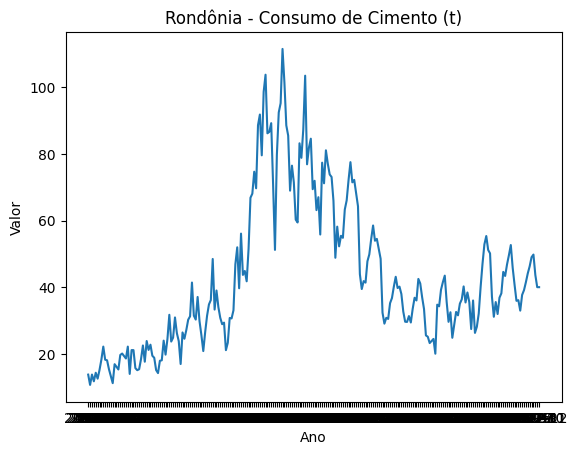

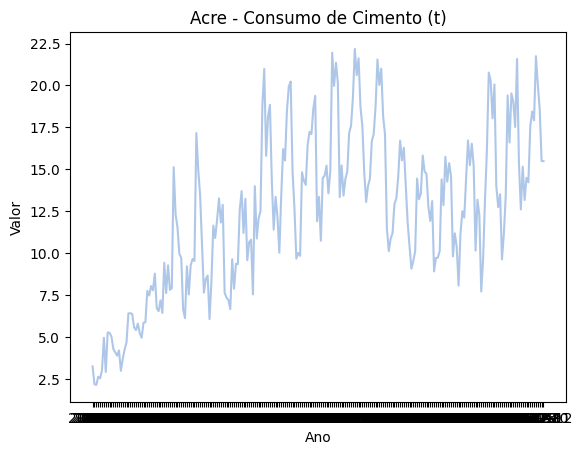

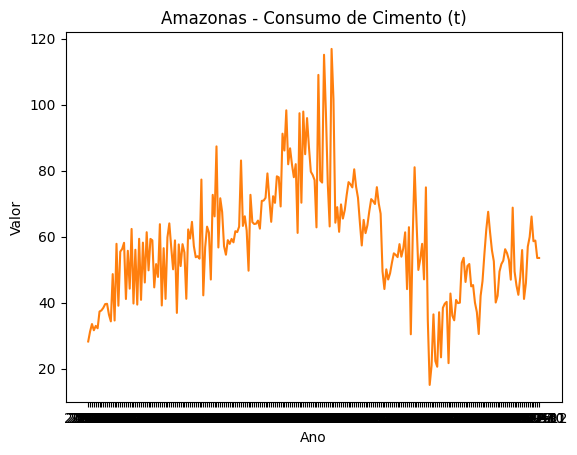

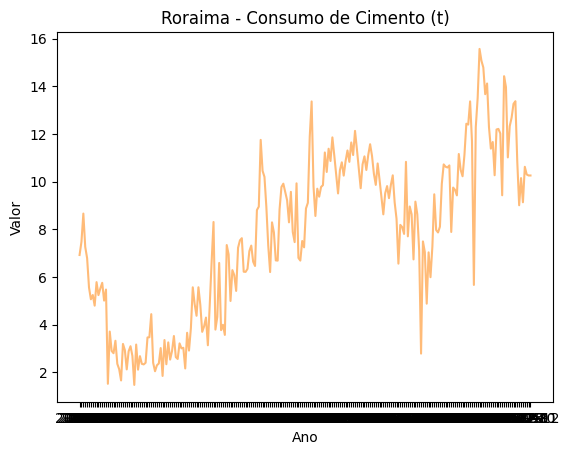

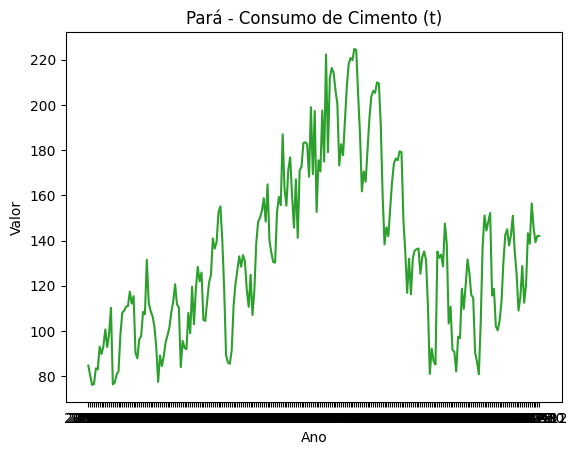

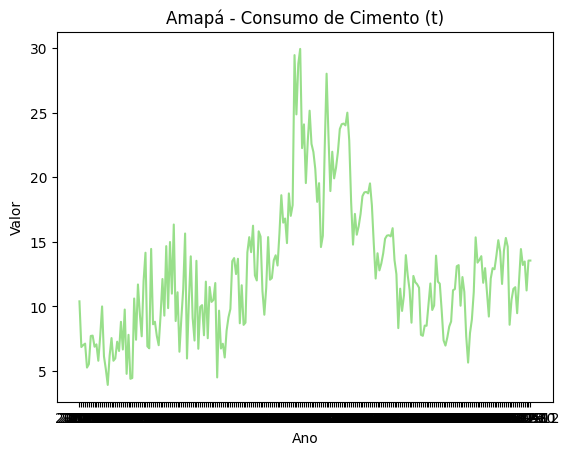

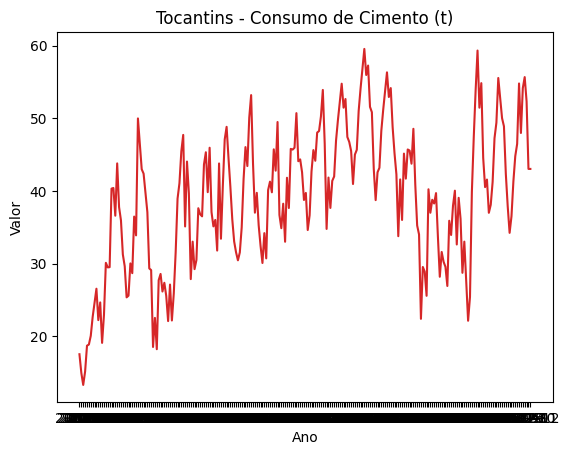

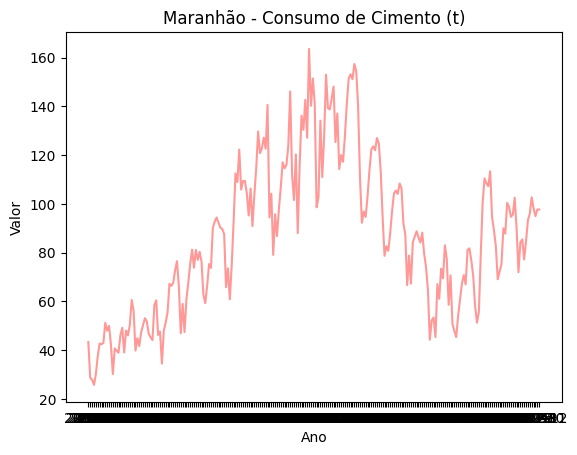

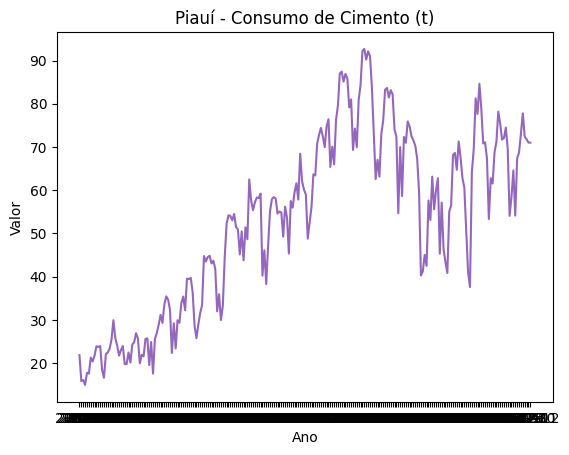

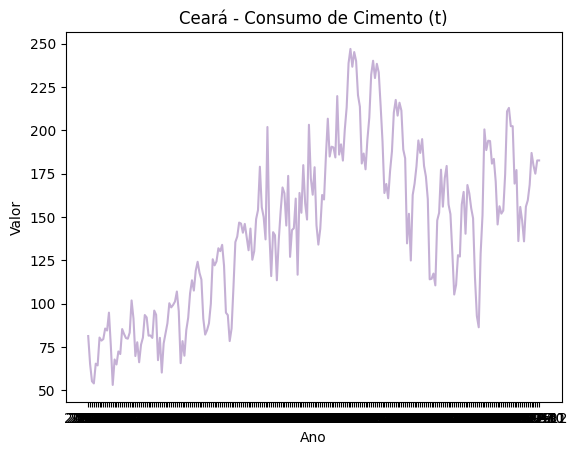

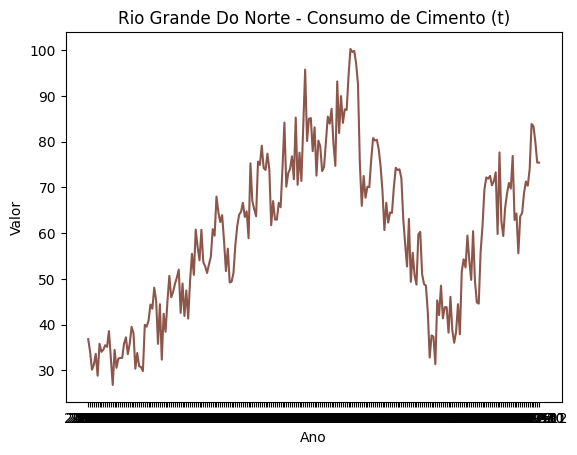

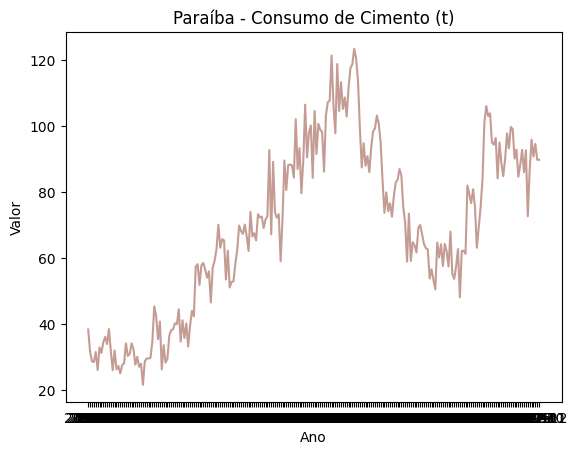

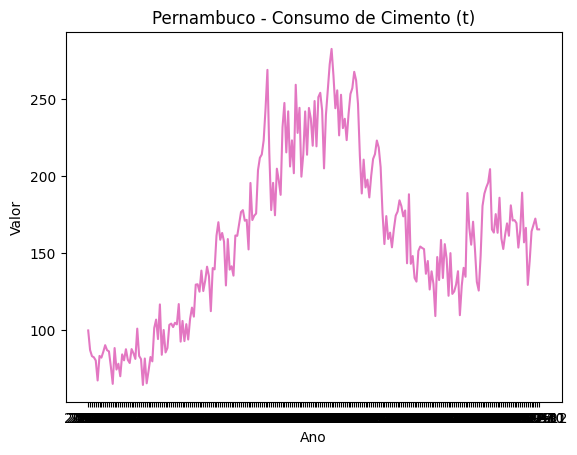

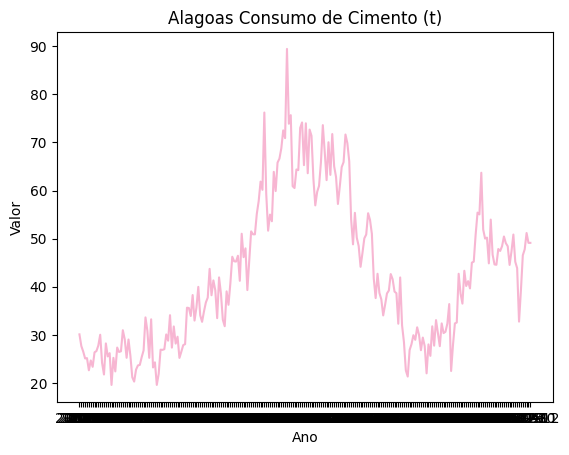

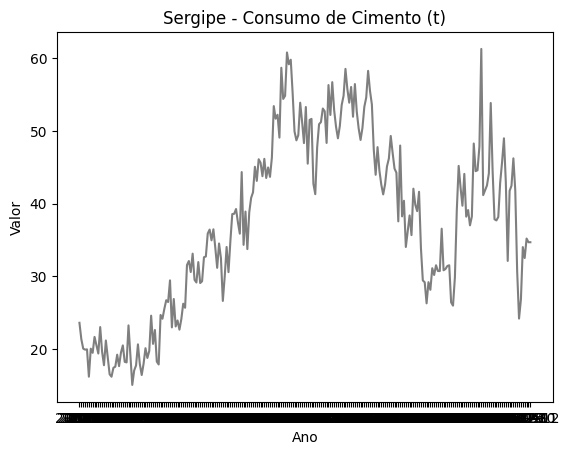

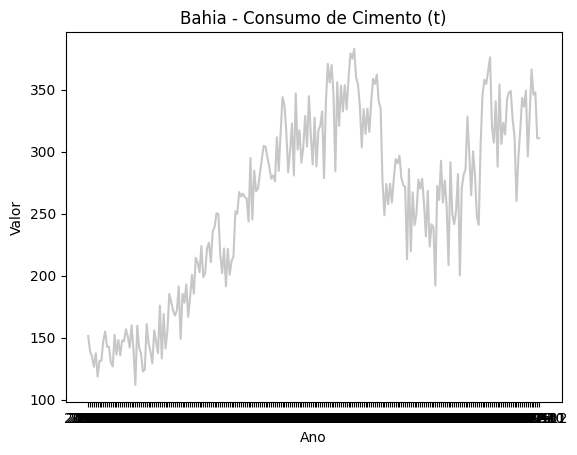

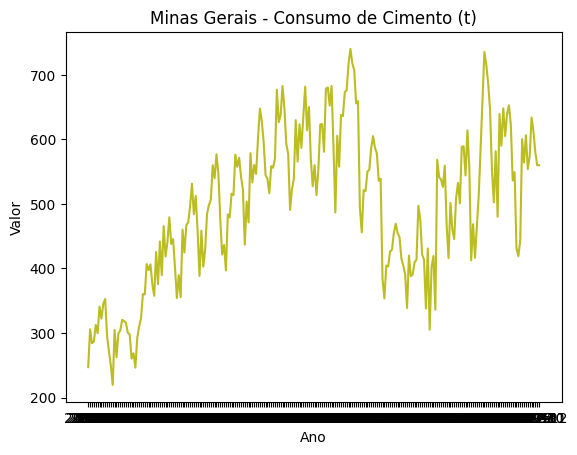

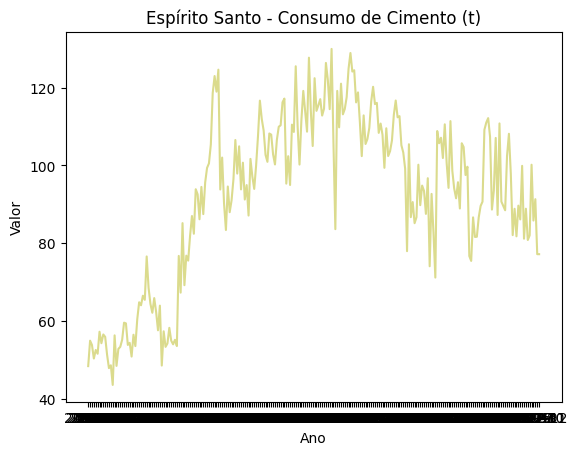

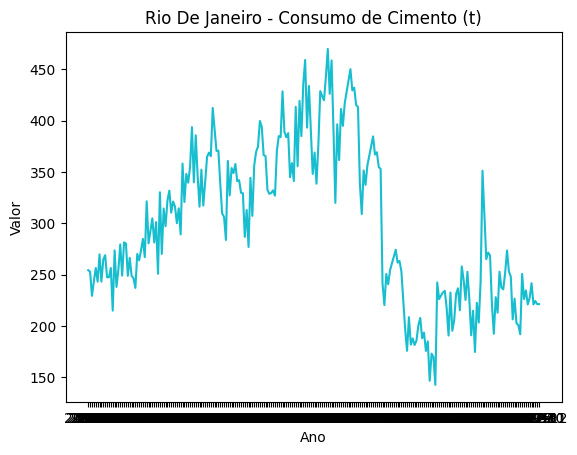

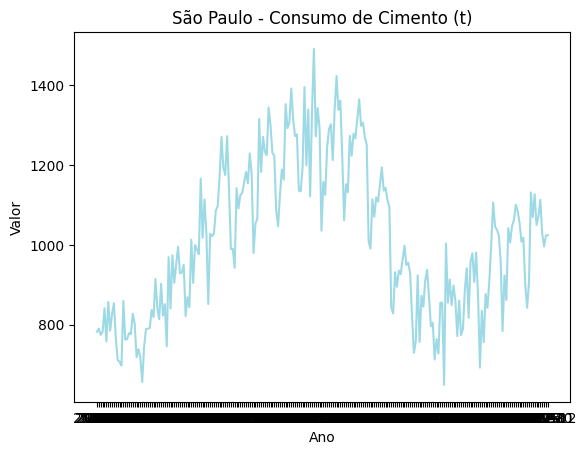

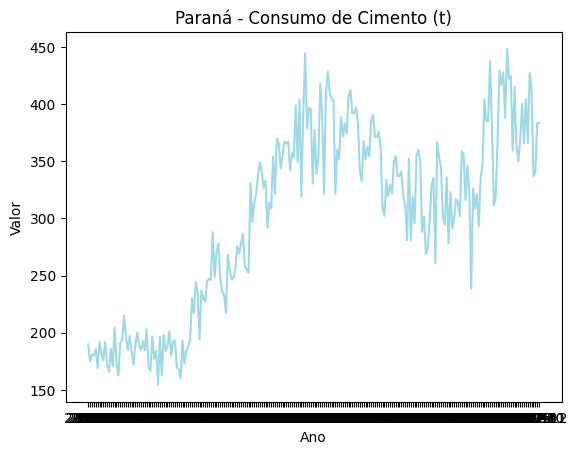

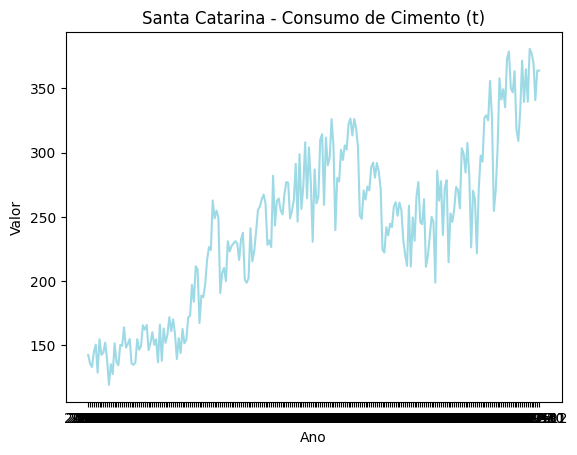

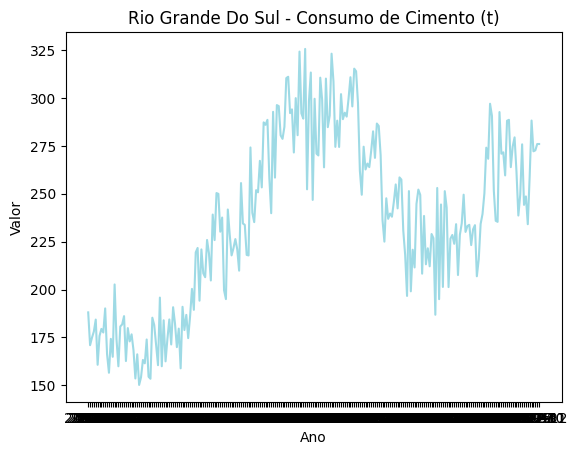

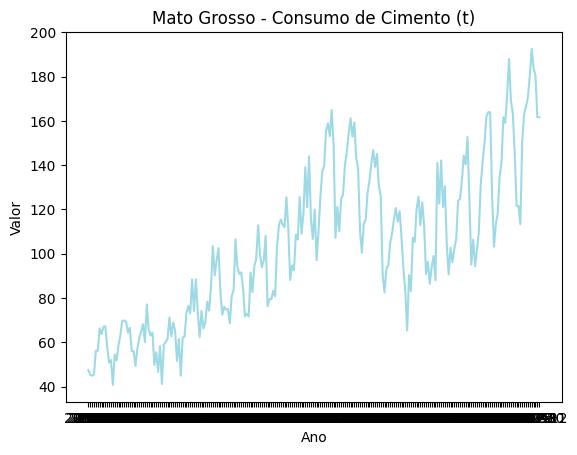

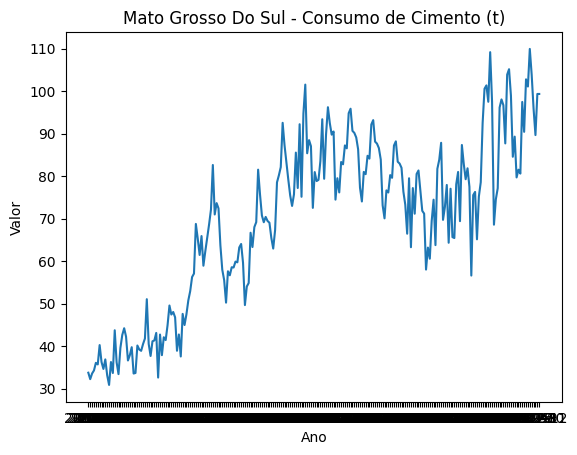

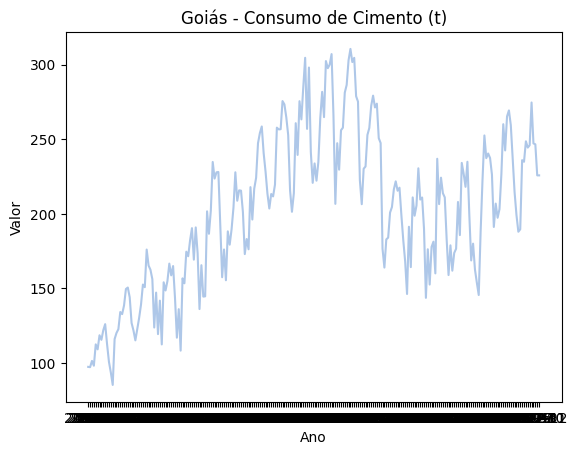

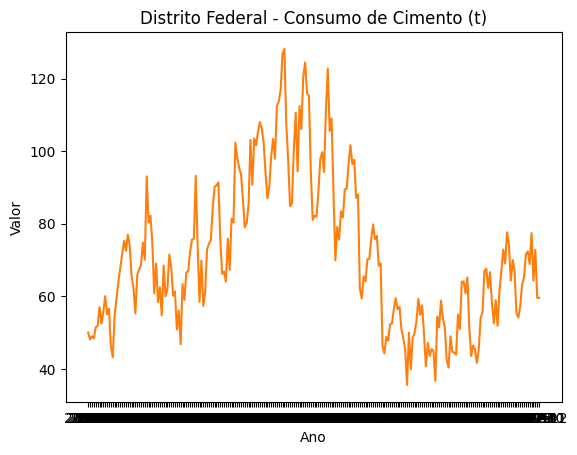

,Rondônia - Consumo de Cimento (t),Acre - Consumo de Cimento (t),Amazonas - Consumo de Cimento (t),Roraima - Consumo de Cimento (t),Pará - Consumo de Cimento (t),Amapá - Consumo de Cimento (t),Tocantins - Consumo de Cimento (t),Maranhão - Consumo de Cimento (t),Piauí - Consumo de Cimento (t),Ceará - Consumo de Cimento (t),...,Espírito Santo - Consumo de Cimento (t),Rio De Janeiro - Consumo de Cimento (t),São Paulo - Consumo de Cimento (t),Paraná - Consumo de Cimento (t),Santa Catarina - Consumo de Cimento (t),Rio Grande Do Sul - Consumo de Cimento (t),Mato Grosso - Consumo de Cimento (t),Mato Grosso Do Sul - Consumo de Cimento (t),Goiás - Consumo de Cimento (t),Distrito Federal - Consumo de Cimento (t)
Ano,,,,,,,,,,,,,,,,,,,,,
2003-1,13.867,3.260,28.193,6.920,84.701,10.392,17.555,43.342,21.844,81.265,...,48.426,254.362,782.111,189.804,142.456,188.093,47.470,33.744,97.447,50.047
2003-2,10.777,2.191,31.226,7.476,80.221,6.857,14.976,28.663,15.814,65.200,...,54.969,252.842,789.891,174.713,135.829,170.973,45.387,32.230,97.256,48.110
2003-3,13.888,2.154,33.484,8.659,76.122,7.011,13.334,27.900,16.067,55.165,...,53.847,229.385,774.309,180.801,133.135,174.880,44.907,33.559,101.442,49.006
2003-4,11.859,2.643,31.596,7.259,76.544,7.122,15.173,25.739,14.938,53.928,...,50.375,243.407,782.071,180.172,144.723,178.111,45.467,34.283,98.217,48.445
2003-5,14.431,2.546,32.919,6.786,83.445,5.267,18.728,30.203,17.765,65.334,...,52.576,256.535,841.400,185.597,150.523,184.331,56.246,36.066,112.540,51.436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-8,49.066,21.748,66.077,9.133,156.442,13.208,54.154,102.698,77.776,186.918,...,100.170,241.702,1112.914,412.177,377.545,288.217,192.533,103.854,274.673,77.448
2022-9,49.850,20.032,58.590,10.622,145.777,13.476,55.664,98.133,72.377,179.828,...,85.832,221.036,1028.144,337.056,370.282,272.178,183.895,95.890,247.240,64.321
2022-10,43.733,18.573,58.793,10.300,139.233,11.236,52.320,94.964,71.791,174.940,...,91.318,224.399,996.449,340.018,340.900,272.665,180.525,89.679,246.647,72.839


In [39]:
df_2015_interpolated_2003 = df_2015_interpolated_2003.reset_index(drop=False)

df_2016_interpolated_2003 = season_interpolation(df_2015_interpolated_2003,
         [430,159,618,118,1962,176,577,1157,909,
          2328,823,962,2040,472,545,3295,5016,1290,
          3021,10982,3941,2923,2924,1244,953,2359,618], 
          monthly_mean_lists, (156, 168))

df_2016_interpolated_2003 = df_2016_interpolated_2003.set_index('Ano').rename_axis('Ano')
plot_columns(df_2016_interpolated_2003)
df_2016_interpolated_2003

In [40]:
for column in df_2016_interpolated_2003.columns:
    file_name = f"2003_mo_cons_cim_{column}.csv"
    column_df = df_2016_interpolated_2003[[column]]
    column_df.to_csv(file_name, index=True)

In [41]:
# df_year = df.copy()
# df_year['Ano'] = df_year['Ano'].str[:4]
# df_year = df_year.groupby('Ano').sum()
# df_year

In [42]:
# df_year.index = df_year.index.astype(int)
# df_2003 = df_year[df_year.index >= 2003] 
# for column in df_2003.columns:
#     file_name = f"2003_01_cons_cim_{column}.csv"
#     column_df = df_2003[[column]]
#     column_df.to_csv(file_name, index=True)

In [43]:
# df_year.index = df_year.index.astype(int)
# df_2014 = df_year[df_year.index >= 2014] 
# df_2014

In [44]:
# for column in df_2014.columns:
#     file_name = f"2014_01_cons_cim_{column}.csv"
#     column_df = df_2014[[column]]
#     column_df.to_csv(file_name, index=True)

In [45]:
# df_year.index = df_year.index.astype(int)
# df_2008 = df_year[df_year.index >= 2008] 
# df_2008

In [46]:
# for column in df_2008.columns:
#     column_words = column.split("-")
#     file_name = f"2008_01_cons_cim_{column_words[0]}.csv"
#     column_df = df_2008[[column]]
#     column_df.to_csv(file_name, index=True)